<a name="TOC"></a>
# Dynamics Tutorial 2: Recipes for Ehrenfest

In this tutorial we will learn:

* [Topic 1](#dynamics) how to setup and run dynamical calculations, using the pre-defined dynamical recipes library


In [7]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py.models import Tully
from libra_py.models import Holstein
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import tsh_algo1
from libra_py import dynamics
from libra_py import dynamics_recipes_Ehrenfest
from libra_py import data_conv

import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

## Define the models

In [8]:
class tmp:
    pass

def my_test_dia_abstract(q, params, full_id):
    """
   
    2-state spin-boson model [Ref: Subotnik, JCP 135, 191101, 2011]

         | 0.5*m*w^2*x^2 + M*x          V                    |
    H =  |                                                   |
         |       V               0.5*m*w^2*x^2 - M*x - eps   |
         

    M = sqrt(E_r * m * w^2 / 2)
    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["omega"]** ( double ):  [ units: a.u. ]
            * **params["E_r"]**   ( double ):  [ units: Ha ]
            * **params["mass"]** ( double ):  [ units: a.u. ]
            * **params["V"]**   ( double ):  [ units: Ha ]
            * **params["epsilon"]**   ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
 
    """


    critical_params = [] 
    default_params = { "omega":3.5e-4, "E_r":2.39e-2, "mass":1.0, "V":1.49e-5, "epsilon":1.5e-2  }
    comn.check_input(params, default_params, critical_params)

    omega = params["omega"]
    E_r = params["E_r"]
    mass = params["mass"]
    V = params["V"]
    epsilon = params["epsilon"]
    
    n = 2

    Hdia = CMATRIX(n,n)
    Sdia = CMATRIX(n,n)
    d1ham_dia = CMATRIXList();  d1ham_dia.append( CMATRIX(n,n) )
    dc1_dia = CMATRIXList();  dc1_dia.append( CMATRIX(n,n) )
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)
    
    Sdia.identity()    
    
    M = omega * math.sqrt(0.5*E_r * mass)
    
    Hdia.set(0,0,  (0.5*mass*omega*omega*x*x + M *x )  * (1.0+0.0j) )
    Hdia.set(1,1,  (0.5*mass*omega*omega*x*x - M *x - epsilon )  * (1.0+0.0j) )
    Hdia.set(0,1,  V  * (1.0+0.0j) )
    Hdia.set(1,0,  V  * (1.0+0.0j) )
            
    d1ham_dia[0].set(0, 0, (omega*omega*x + M)*(1.0+0.0j) )    
    d1ham_dia[0].set(1, 1, (omega*omega*x - M)*(1.0+0.0j) )    
    d1ham_dia[0].set(0, 1, (0.0+0.0j) )    
    d1ham_dia[0].set(1, 0, (0.0+0.0j) )    
            
                    
    obj = tmp()
    obj.ham_dia = Hdia
    obj.ovlp_dia = Sdia
    obj.d1ham_dia = d1ham_dia
    obj.dc1_dia = dc1_dia

    return obj


def my_test_adi_abstract(q, params, full_id):
    """
   
    2-state spin-boson model [Ref: Subotnik, JCP 135, 191101, 2011]

         | 0.5*m*w^2*x^2 - eps/2 - sqrt( (eps/2 + M*x)^2 + V^2 )          d12 * i          |
    H =  |                                                                                 | 
         |       -d12 * i      0.5*m*w^2*x^2 - eps/2 - sqrt( (eps/2 + M*x)^2 + V^2 )       |
         

    M = sqrt(E_r * m * w^2 / 2)
    
    d12 = 0.5 * M * V / [ (eps/2 +  M*x)^2 + V^2 ]
    

    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof = 1
        params ( dictionary ): model parameters

            * **params["omega"]** ( double ):  [ units: a.u. ]
            * **params["E_r"]**   ( double ):  [ units: Ha ]
            * **params["mass"]** ( double ):  [ units: a.u. ]
            * **params["V"]**   ( double ):  [ units: Ha ]
            * **params["epsilon"]**   ( double ):  [ units: Ha ]

    Returns:       
        PyObject: obj, with the members:

            * obj.ham_dia ( CMATRIX(n,n) ): diabatic Hamiltonian 
            * obj.ovlp_dia ( CMATRIX(n,n) ): overlap of the basis (diabatic) states [ identity ]
            * obj.d1ham_dia ( list of 1 CMATRIX(n, n) objects ): 
                derivatives of the diabatic Hamiltonian w.r.t. the nuclear coordinate
            * obj.dc1_dia ( list of 1 CMATRIX(n, n) objects ): derivative coupling in the diabatic basis [ zero ]
    """


    critical_params = [] 
    default_params = { "omega":3.5e-4, "E_r":2.39e-2, "mass":1.0, "V":1.49e-5, "epsilon":1.5e-2  }
    comn.check_input(params, default_params, critical_params)

    omega = params["omega"]
    E_r = params["E_r"]
    mass = params["mass"]
    V = params["V"]
    epsilon = params["epsilon"]
    
    n = 2

    Hadi = CMATRIX(n,n)
    d1ham_adi = CMATRIXList();  d1ham_adi.append( CMATRIX(n,n) )
    dc1_adi = CMATRIXList();  dc1_adi.append( CMATRIX(n,n) )
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)

    
    M = omega * math.sqrt(0.5*E_r * mass)
    
    t = (epsilon/2.0 +  M*x)**2 + V * V 
    tsq = math.sqrt(t)
    dtsq = M * (epsilon/2.0 + M*x)/tsq   # d [tsq]/dx
    d = 0.5*M*V/t
        
    
    Hadi.set(0,0,  (0.5*mass*omega*omega*x*x - 0.5*epsilon - tsq) * (1.0+0.0j) )
    Hadi.set(1,1,  (0.5*mass*omega*omega*x*x - 0.5*epsilon + tsq) * (1.0+0.0j) )
    Hadi.set(0,1,  (0.0+0.0j) )
    Hadi.set(1,0,  (0.0+0.0j) )
            
    d1ham_adi[0].set(0, 0, (omega*omega*x - dtsq )*(1.0+0.0j) )    
    d1ham_adi[0].set(1, 1, (omega*omega*x + dtsq )*(1.0+0.0j) )    
    d1ham_adi[0].set(0, 1, (0.0+0.0j) )    
    d1ham_adi[0].set(1, 0, (0.0+0.0j) )    
    
    dc1_adi[0].set(0, 1, d*(1.0+0.0j) )    
    dc1_adi[0].set(1, 0, d*(-1.0+0.0j) )    
    dc1_adi[0].set(0, 0, (0.0+0.0j) )    
    dc1_adi[0].set(1, 1, (0.0+0.0j) )    
            
                    
    obj = tmp()
    obj.ham_adi = Hadi    
    obj.d1ham_adi = d1ham_adi
    obj.dc1_adi = dc1_adi

    return obj


In [9]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:
        res = my_test_dia_abstract(q, params, full_id)
    elif model==2:
        res = my_test_adi_abstract(q, params, full_id)
    elif model==3:    
        pass

    return res


## Plot the Hamiltonians

In [10]:
xmin = -500.0
xmax = 300.0
dx = 1.0

X = []
nsteps = int((xmax - xmin) / dx) + 1

for i in range(nsteps):
    X.append(xmin + i * dx)

In [11]:
def plot_properties(grid, comp_model, model_params, dyn_params):

    ndia, nadi, ndof = 2, 2, 1
    
    rep_tdse = dyn_params["rep_tdse"]  # what we want

    # ======= Hierarchy of Hamiltonians =======
    tol = 0.01
    ham = nHamiltonian(ndia, nadi, ndof)
    ham.init_all(2)
    ham.phase_corr_ovlp_tol = tol

    ham1 = [] 
    for tr in range(1):
        ham1.append( nHamiltonian(ndia, nadi, ndof) )        
        ham1[tr].init_all(2)
        ham1[tr].phase_corr_ovlp_tol = tol
        ham.add_child(ham1[tr])

    projectors = CMATRIXList()
    for tr in range(1):
        projectors.append(CMATRIX(nadi, nadi))
        projectors[tr].identity()        
    

    # Energies, forces, and couplings    
    H00, H11, H01 = [], [], []
    dH00, dH11, dH01 = [], [], []
    d01 = []
    
    nsteps = len(grid)
    
    tid = Py2Cpp_int([0, 0])
    
    for i in range(nsteps):
        q = MATRIX(1,1); q.set(0, 0, grid[i])
            
        update_Hamiltonian_q(dyn_params, q, projectors, ham, compute_model, model_params)
        
        if rep_tdse==0:    
            H00.append(ham.get_ham_dia(tid).get(0,0).real)
            H11.append(ham.get_ham_dia(tid).get(1,1).real)
            H01.append(ham.get_ham_dia(tid).get(0,1).real)    
    
            
            dH00.append(ham.get_d1ham_dia(0,tid).get(0,0).real)
            dH11.append(ham.get_d1ham_dia(0,tid).get(1,1).real)            
            dH01.append(ham.get_d1ham_dia(0,tid).get(0,1).real) 
            
            d01.append(ham.get_dc1_dia(0,tid).get(0,1).real)
            
        elif rep_tdse==1:    
            H00.append(ham.get_ham_adi(tid).get(0,0).real)
            H11.append(ham.get_ham_adi(tid).get(1,1).real)
            H01.append(ham.get_ham_adi(tid).get(0,1).real)    
    
            dH00.append(ham.get_d1ham_adi(0,tid).get(0,0).real)
            dH11.append(ham.get_d1ham_adi(0,tid).get(1,1).real)            
            dH01.append(ham.get_d1ham_adi(0,tid).get(0,1).real) 
            
            d01.append(ham.get_dc1_adi(0,tid).get(0,1).real)            
            
            
    #======== Now lets plot what we have computed ===========
    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(1,3,1)
    plt.title('Energies and couplings')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(grid, H00, label='H00', linewidth=2, color = colors["11"]) 
    plt.plot(grid, H11, label='H11', linewidth=2, color = colors["21"]) 
    plt.plot(grid, H01, label='H01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(1,3,2)
    plt.title('Derivatives')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u./Bohr')
    plt.plot(grid, dH00, label='dH00', linewidth=2, color = colors["11"]) 
    plt.plot(grid, dH11, label='dH11', linewidth=2, color = colors["21"]) 
    plt.plot(grid, dH01, label='dH01', linewidth=2, color = colors["31"]) 
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.title('Derivative couplings')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u./Bohr')
    plt.plot(grid, d01, label='d01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()

Lets consider 3 options:

### Option 1. 

We want diabatic properties and the model Hamiltonian does return the diabatic properties

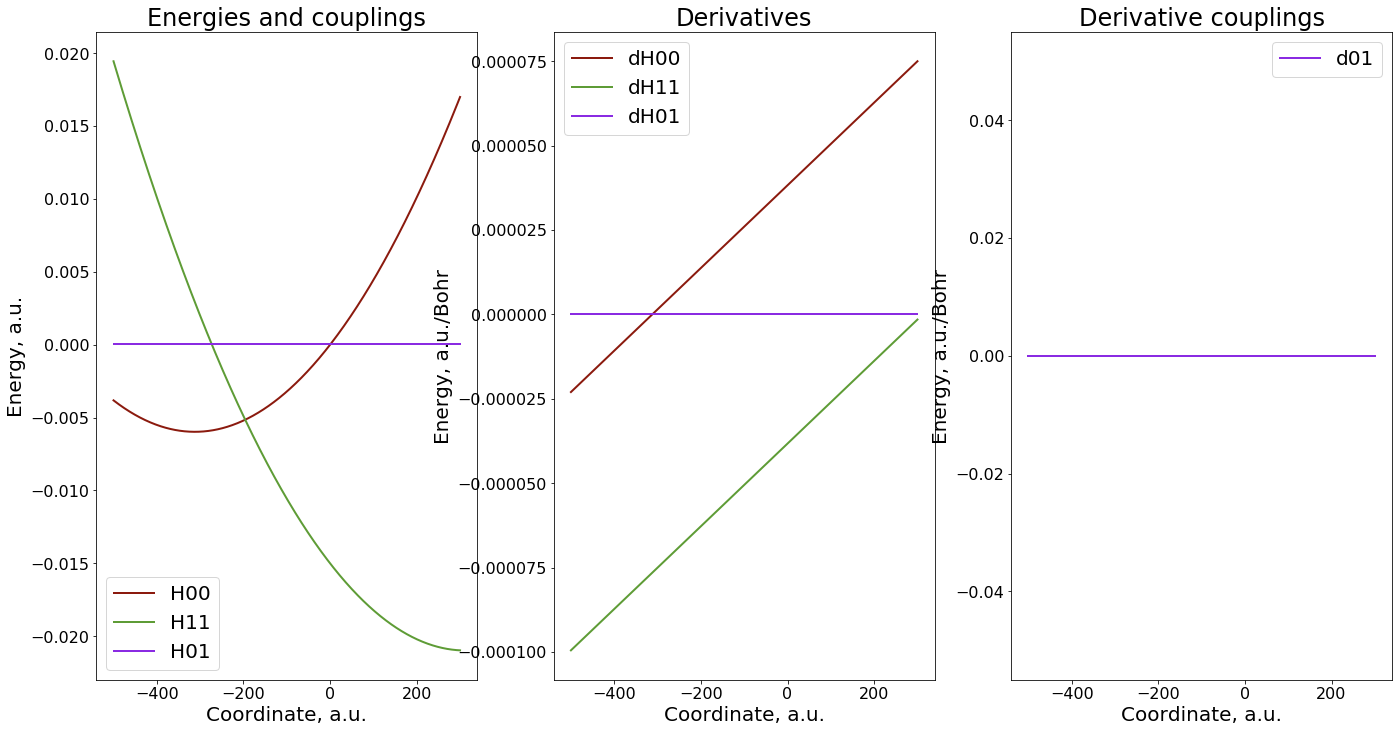

In [12]:
plot_properties(X, compute_model, {"model":1}, {"rep_tdse":0, "rep_ham":0} )

### Option 2.
Now, we want adiabatic properties but the model returns only the diabatic properties, so the needed calculations will be done under the hood

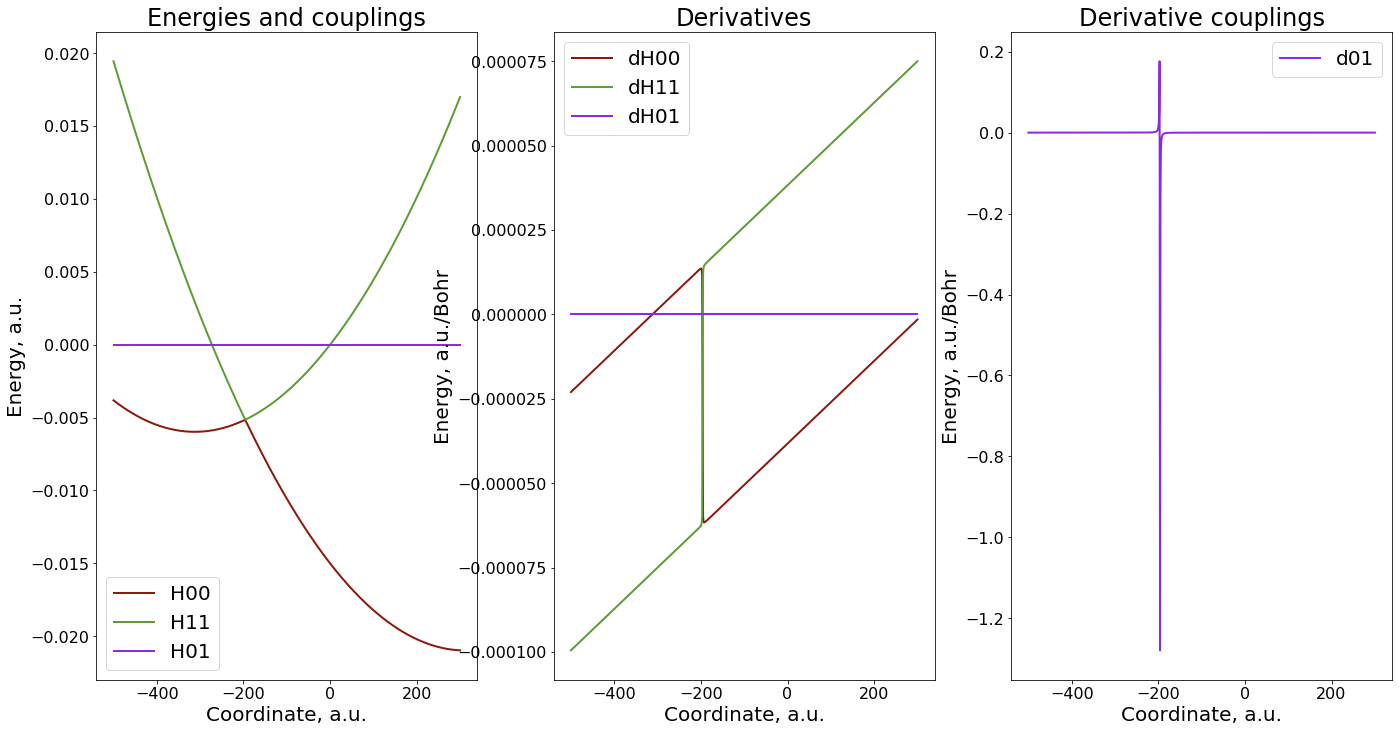

In [13]:
plot_properties(X, compute_model, {"model":1}, {"rep_tdse":1, "rep_ham":0} )

### Option 3.
Finally, we want adiabatic properties - and out Hamiltonian already returns them via analytical expression - so no additional diaginalization is dune.

Note, how we also requested another model to be called in the model_parameters (third argument).

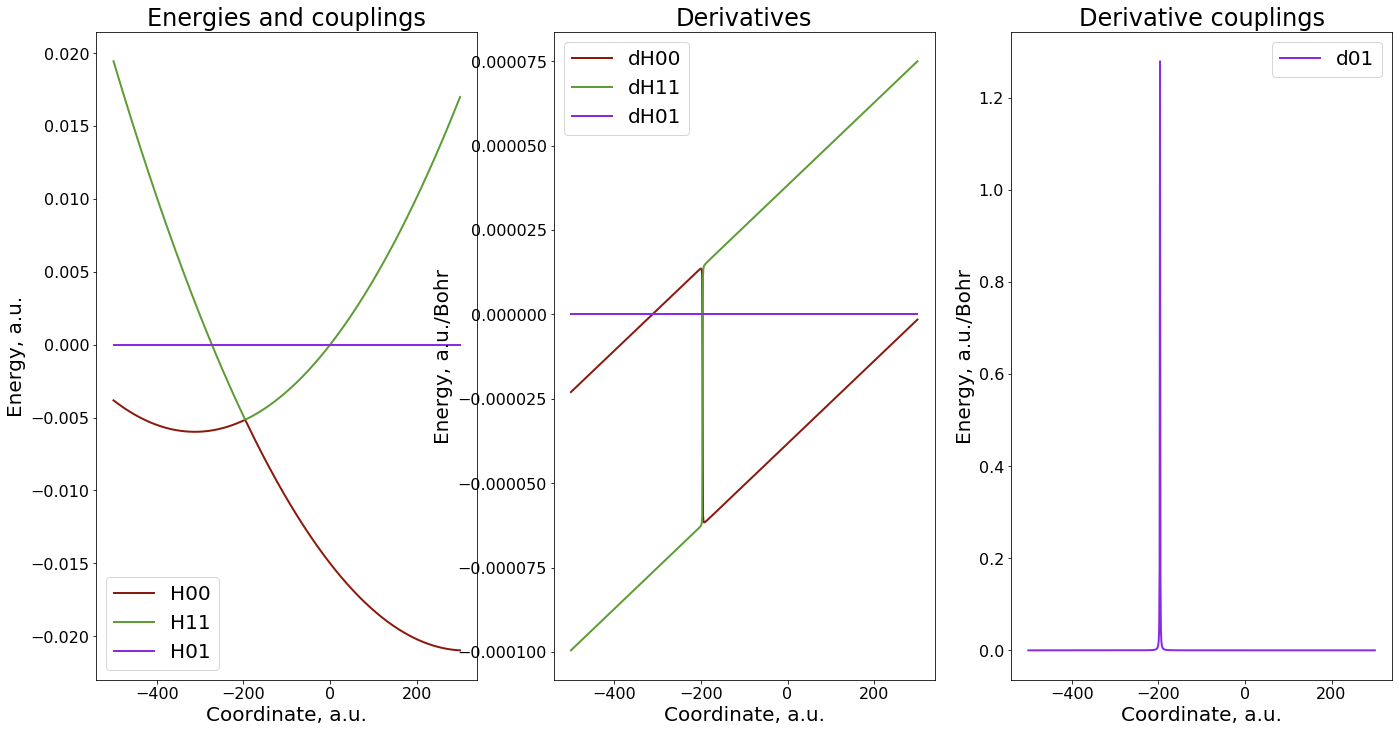

In [14]:
plot_properties(X, compute_model, {"model":2}, {"rep_tdse":1, "rep_ham":1} )

<a name="initial-conditions"></a> [Back to TOC](#TOC)
## Set up the initial conditions

Before, we run the calculations, we need to initialize our dynmaical variables - both electronic and nuclear. There are many options to do this.


* A. Initial conditions in adiabatic rep
* B. Initial conditions in diabatic rep


In [15]:
# Random numbers generator object
rnd = Random()

ntraj = 25

# Initialize nuclear variables
init_nucl = {"init_type":3, "force_constant":[0.001], "ntraj":ntraj}
q, p, iM = dynamics.init_nuclear_dyn_var([-300.0], [20.0], [2000.0], init_nucl, rnd)


init_elec = { "init_type":3, "nstates":2, "istates":[0.0, 1.0],  "ntraj":ntraj  }

Since in all examples below, we want to focus only on the methodologies, we will keep the initial conditions identical for all cases.

We also assume we start at the first (left) diabatic surface.

What is convenient in the setup below is that once the initial conditions are generated in one place, the identical copies will be used in each of the consecutive runs. The dynamical variables like q, p, etc. are not modified inside of the functions, Instead, new copies will be created internally and THEY will be modified and printed out (if requested), not the variables we put as the input below. This is convenient, since we can then use the same random samplings in all the runs. 

<a name="dynamics"></a> [Back to TOC](#TOC)

## Compute the dynamics - a single scattering run


There are several scenarios of how NA-MD can be run.

In this tutorial we focus solely on the **Ehrenfest dynamics** methods, so (``force_method = 2``)

1. TDSE amplitudes in adiabatic rep (``rep_tdse = 1``)
 
  [1.1.](#case-1-1) **Ehrenfest_dia0_adi_diah** Ham is given in diabatic rep and converted to adiabatic (``rep_ham = 0``), init amplitudes in diabatic rep
  
  [1.2.](#case-1-2) **Ehrenfest_adi0_adi_diah** Ham is given in diabatic rep and converted to adiabatic (``rep_ham = 0``), init amplitudes in adiabatic rep
  
  [1.3.](#case-1-3) **Ehrenfest_dia0_adi_adih** Ham is given in adiabatic rep already (``rep_ham = 1``),  init amplitudes in diabatic rep
  
  [1.4](#case-1-4) **Ehrenfest_adia_adi_adih** Ham is given in adiabatic rep already (``rep_ham = 1``),  init amplitudes in adiabatic rep
  
2. TDSE amplitudes in diabatic rep (``rep_tdse = 0``)
  
  [2.1.](#case-2-1) **Ehrenfest_dia0_dia_diah** Ham is given in diabatic rep (``rep_ham = 0``), init amplitudes in diabatic rep
  
  [2.2.](#case-2-2) **Ehrenfest_adi0_dia_diah** Ham is given in diabatic rep (``rep_ham = 0``), init amplitudes in adiabatic rep
   
      
---

In addition, a number of settings can be kept fixed - they are outside of our current focus, so can be defined here only once

In [16]:
dyn_params = { "rep_tdse":1, "rep_ham":0, "rep_sh":1, "rep_lz":0, "tsh_method":-1,
               "force_method":2, "nac_update_method":1, "rep_force":1,
               "use_boltz_factor":0, "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":1,
               "do_phase_correction":1, "tol":1e-3,
               "state_tracking_algo":2, "MK_alpha":0.0, "MK_verbosity":0, 
               "entanglement_opt":0, "ETHD3_alpha":0.0, "ETHD3_beta":0.0, 
               "dt":1.0*units.fs2au, "nsteps":500, 
               "output_level":2, "file_output_level":0
              }

Also, lets define a function for plotting properties of interest

In [17]:
def plot_dyn(res):
    # Format: 
    #   0      1      2       3        4        5           6          7        8            9       10        11            12        13       14         15             16          17
    #obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states obs_hvib_adi obs_hvib_dia  obs_St

    obs_T = res[0]
    obs_Ekin = res[3]
    obs_Epot = res[4]
    obs_Etot = res[5]
    obs_dEkin = res[6]
    obs_dEpot = res[7]
    obs_dEtot = res[8]
    obs_dm_adi00 = data_conv.unpack1(res[11], 0, 0, 0)
    obs_dm_adi11 = data_conv.unpack1(res[11], 1, 1, 0)
    obs_dm_dia00 = data_conv.unpack1(res[12], 0, 0, 0)
    obs_dm_dia11 = data_conv.unpack1(res[12], 1, 1, 0)
    obs_pop00 = data_conv.unpack1(res[13], 0, 0, 2)
    obs_pop11 = data_conv.unpack1(res[13], 1, 0, 2)
    obs_q = data_conv.unpack1(res[1], 0, 0, 2)
    obs_p = data_conv.unpack1(res[2], 0, 0, 2)
    
    ndof = res[1][0].num_of_rows
    ntraj = res[1][0].num_of_cols
    

    plt.figure(1, figsize=(24, 24)) # dpi=300, frameon=False)

    plt.subplot(3,2,1)
    plt.title('q-t')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Coordiante, a.u.')
    
    for tr in range(ntraj):
        obs_q = data_conv.unpack1(res[1], 0, tr, 2)
        plt.plot(obs_T, obs_q, label="", linewidth=2, color = colors["11"])   # label='q vs. t'
    plt.legend()

    plt.subplot(3,2,2)
    plt.title('Phase portrait')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Momentum, a.u.')    
    for tr in range(ntraj):
        obs_q = data_conv.unpack1(res[1], 0, tr, 2)
        obs_p = data_conv.unpack1(res[2], 0, tr, 2)
        plt.plot(obs_q, obs_p, linewidth=2, color = colors["11"])  # label='p vs. q'
    plt.legend()

    plt.subplot(3,2,3)
    plt.title('Adiabatic populations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population of state 0')
    plt.plot(obs_T, obs_pop00, "--o", label='SH P(0)', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dm_adi00, "--o", label='SE P(0)', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_pop11, "--", label='SH P(1)', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dm_adi11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(3,2,4)
    plt.title('Diabatic populations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population of state 0')
    plt.plot(obs_T, obs_dm_dia00, label='SE P(0)', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_dm_dia11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(3,2,5)
    plt.title('Energies')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(obs_T, obs_Ekin, label='Ekin', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_Epot, label='Epot', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_Etot, label='Etot', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(3,2,6)
    plt.title('Energy fluctuations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(obs_T, obs_dEkin, label='dEkin', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dEpot, label='dEpot', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_dEtot, label='dEtot', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()

Now lets consider all the options

<a name="case-1-1"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 1.1.    

* Initial conditions - **diabatic**
* TDSE propagation - **adiabatic**
* Hamiltonian function return - **diabatic** properties


No handles with labels found to put in legend.
No handles with labels found to put in legend.


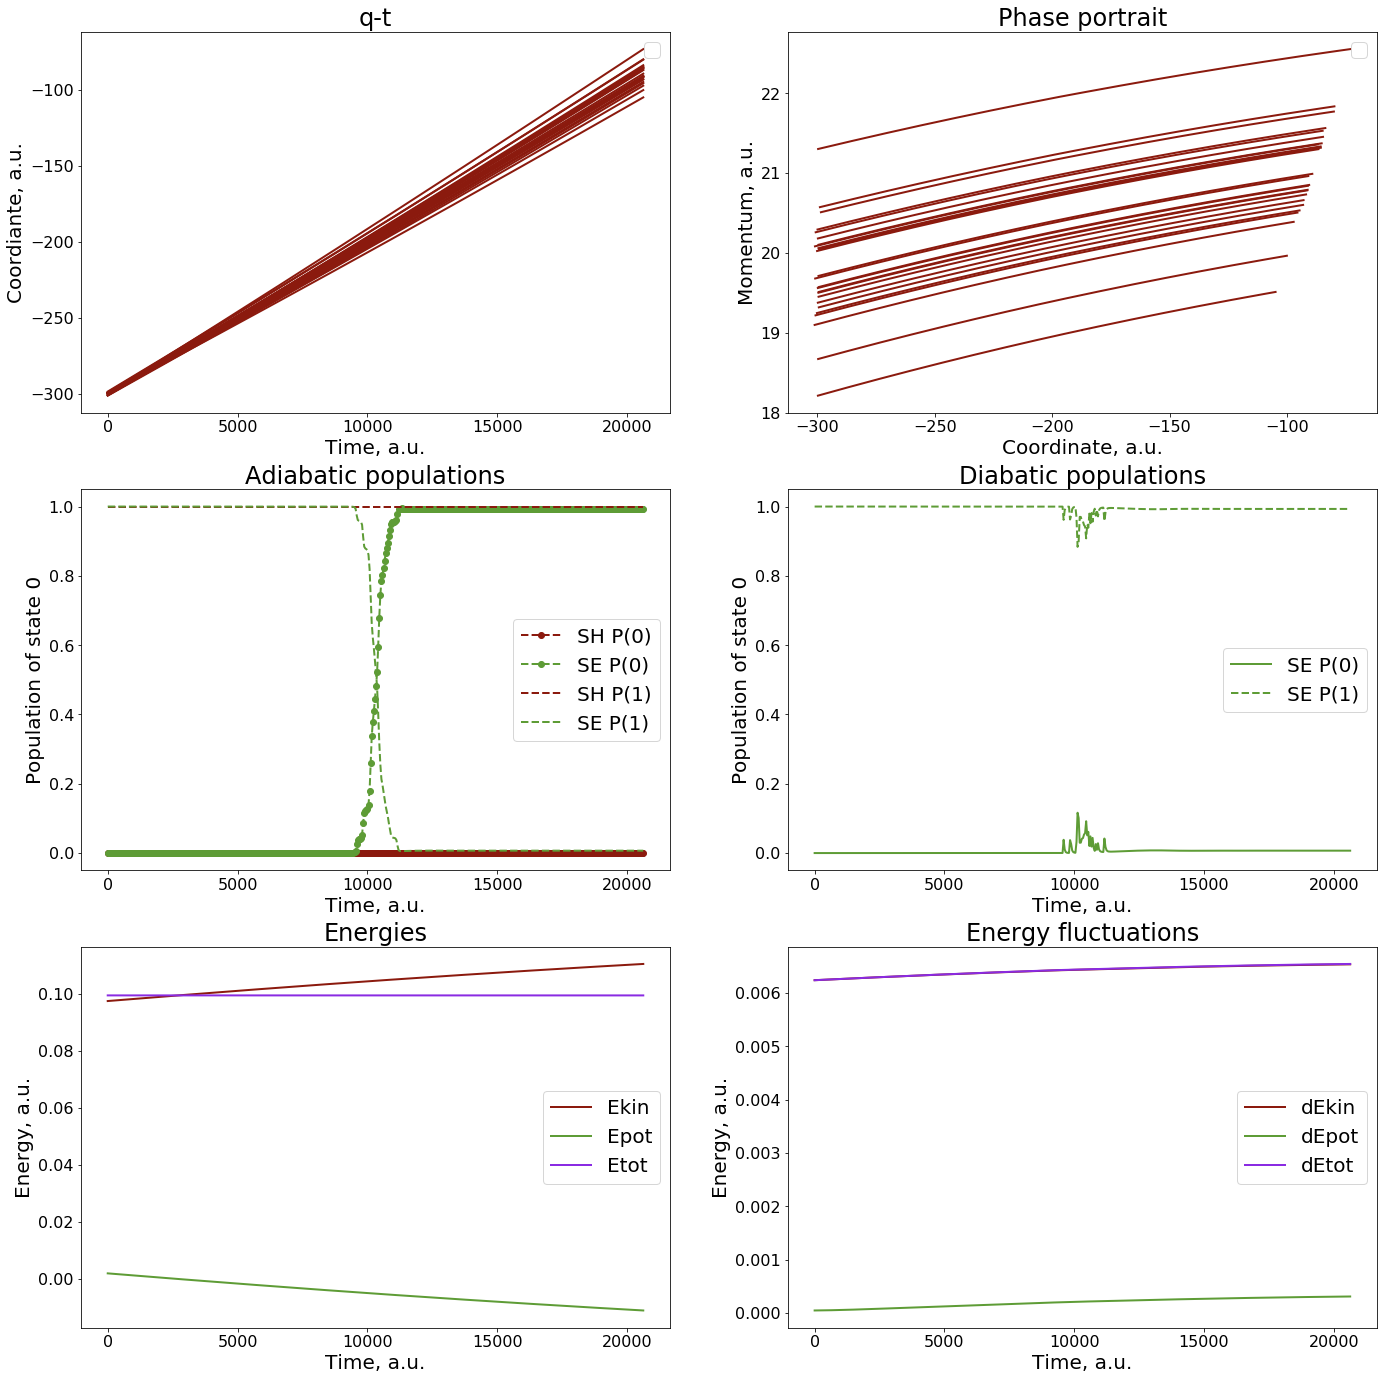

In [18]:
dyn_params.update({"prefix":"T2-1-1"}) 
model_params = {"model":1, "model0":1}
res = dynamics_recipes_Ehrenfest.Ehrenfest_dia0_adi_diah(q, p, iM, dyn_params, compute_model, model_params, init_elec, rnd)
plot_dyn(res)

<a name="case-1-2"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 1.2. 

* Initial conditions - **adiabatic**
* TDSE propagation - **adiabatic**
* Hamiltonian function return - **diabatic** properties

No handles with labels found to put in legend.
No handles with labels found to put in legend.


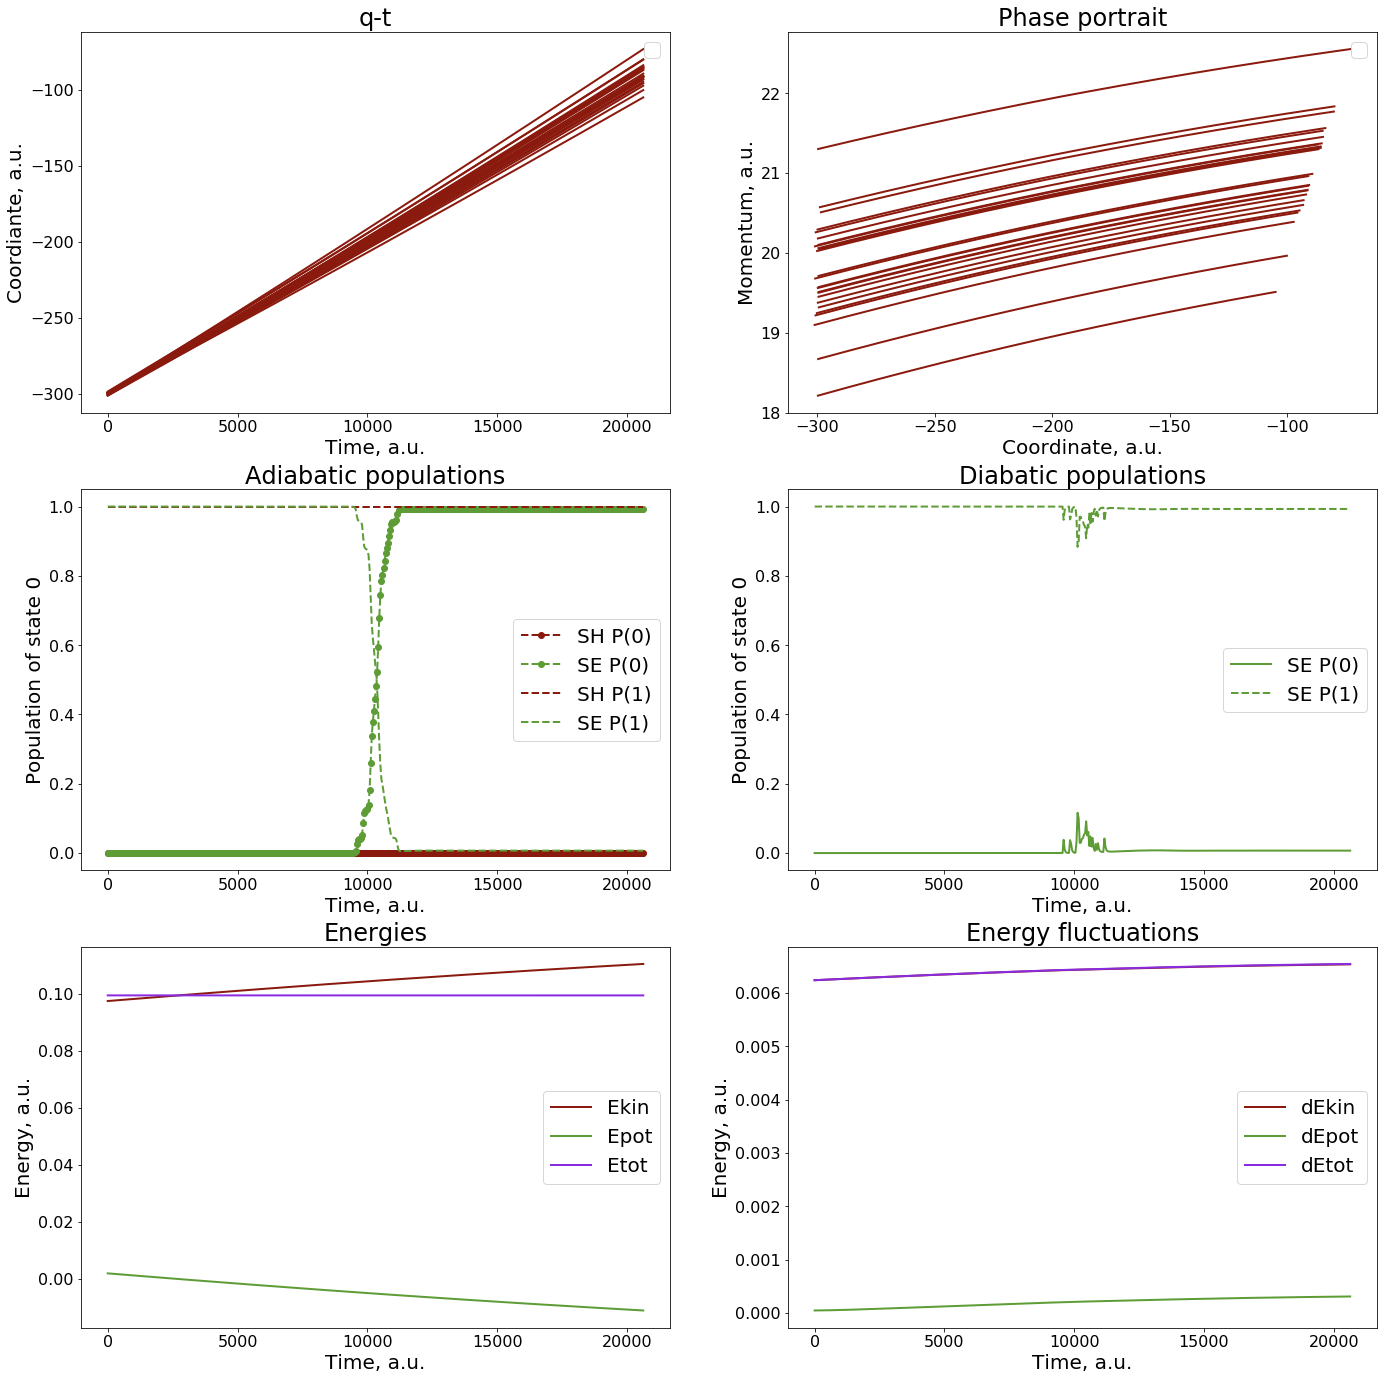

In [19]:
# Initialize electronic variables
dyn_params.update({"prefix":"T2-1-2"}) 
model_params = {"model":1, "model0":1}
res = dynamics_recipes_Ehrenfest.Ehrenfest_adi0_adi_diah(q, p, iM, dyn_params, compute_model, model_params, init_elec, rnd)
plot_dyn(res)

<a name="case-1-3"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 1.3. 

* Initial conditions - **diabatic**
* TDSE propagation - **adiabatic**
* Hamiltonian function return - **adiabatic** properties

Unless we provide MOs (adiabatic - diabatic transformation matrix), we can't use state tracking. So, in this case we temporarily turn the state tracking off.

In addition, note that in ``model_params`` we use two different model indices for ``model`` and ``model0``. This is needed to be able to convert initial diabatic amplitudes into adiabatic ones. This option of course can not be used if the diabatic Hamiltonian (``model0 = 1`` in this case) is not known.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


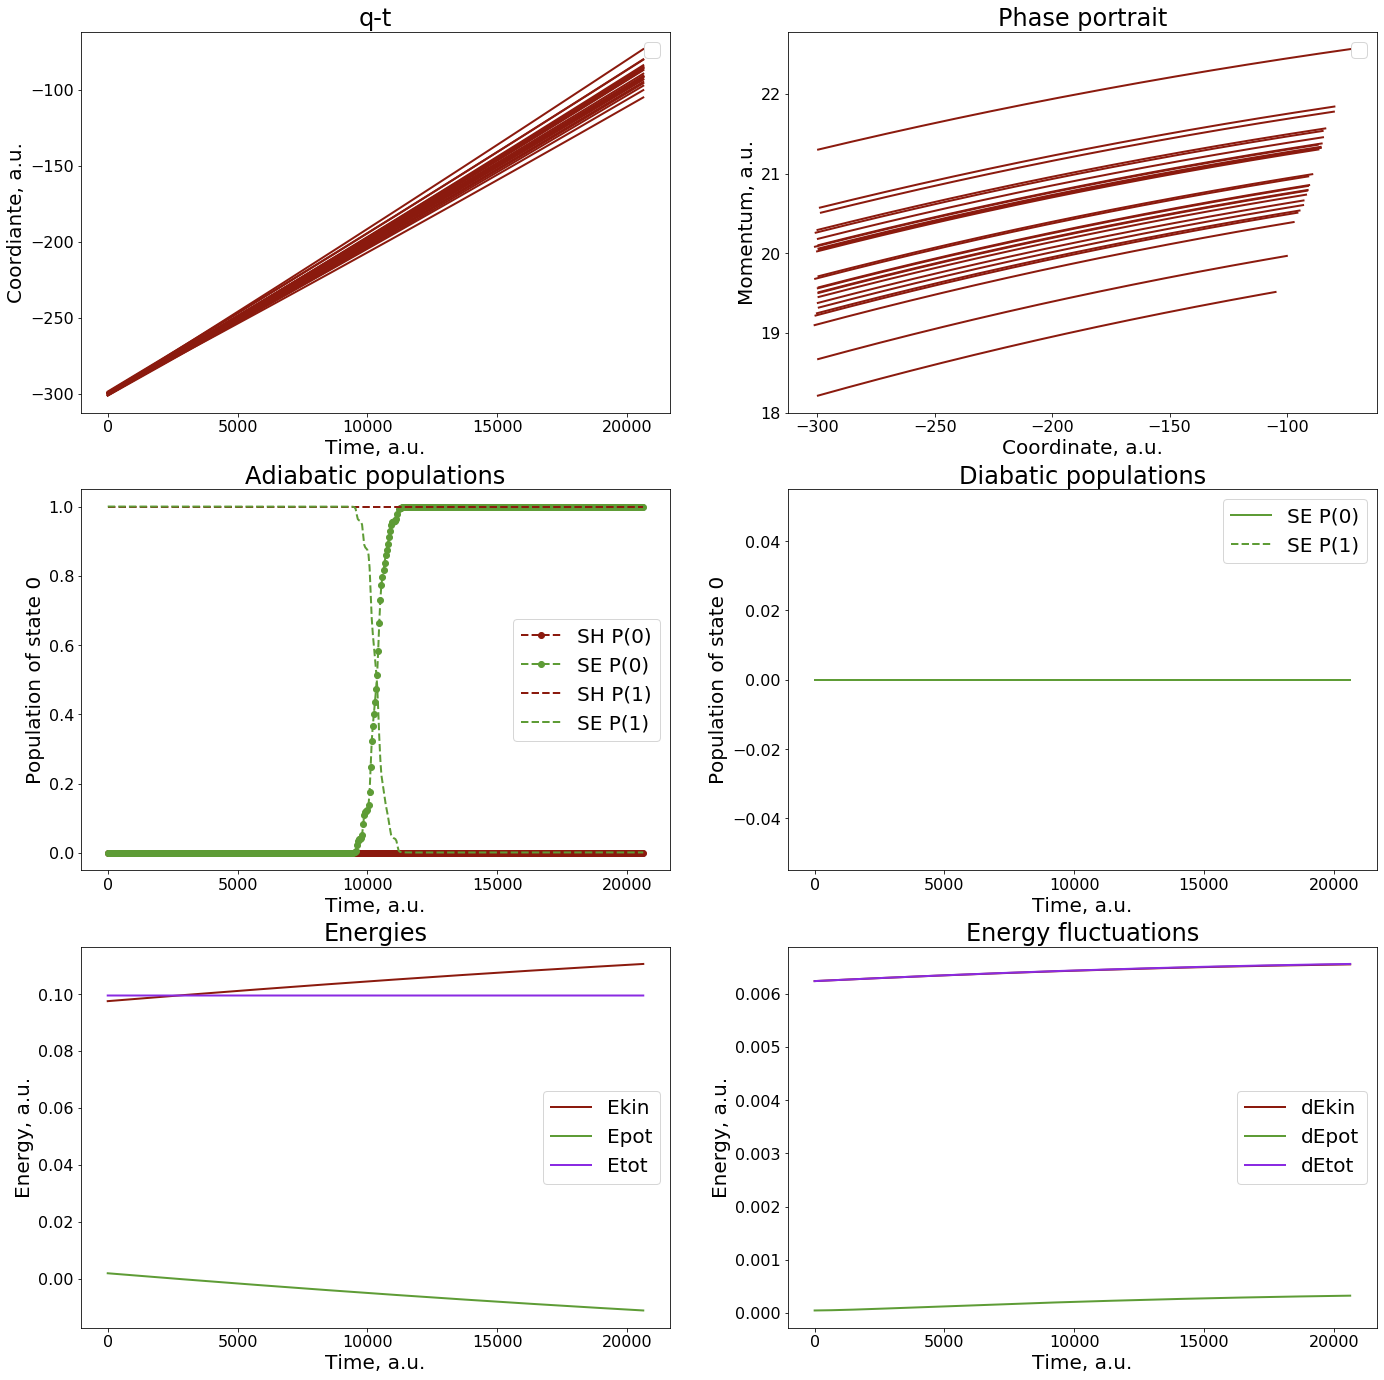

In [20]:
dyn_params.update({"prefix":"T2-1-3", "do_phase_correction":0}) 
model_params = {"model":2, "model0":1}
res = dynamics_recipes_Ehrenfest.Ehrenfest_dia0_adi_adih(q, p, iM, dyn_params, compute_model, model_params, init_elec, rnd)
dyn_params["do_phase_correction"]=1
plot_dyn(res)

<a name="case-1-4"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 1.4. 

* Initial conditions - **adiabatic**
* TDSE propagation - **adiabatic**
* Hamiltonian function return - **adiabatic** properties

Unless we provide MOs (adiabatic - diabatic transformation matrix), we can't use state tracking. So, in this case we temporarily turn the state tracking off.

Note that in thise case, ``model0`` can be the same as ``model`` (both adiabatic), since we already know the adiabatic amplitudes initially. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


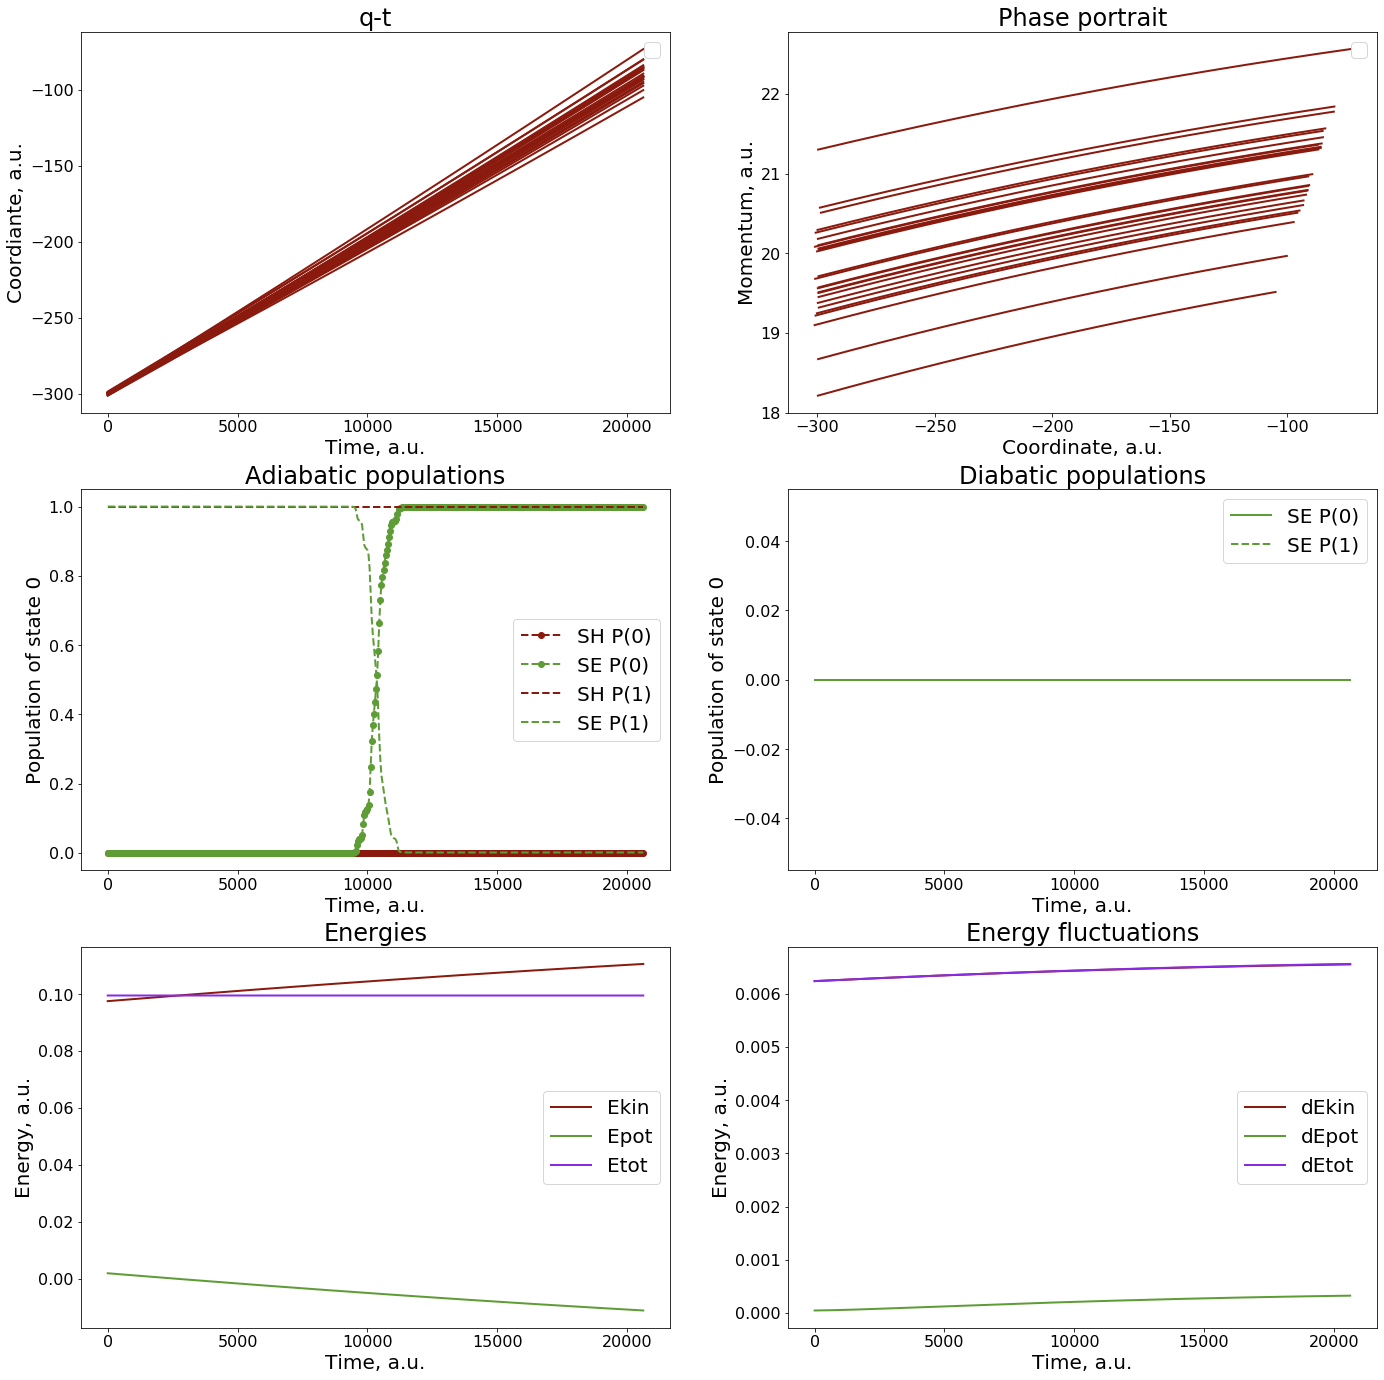

In [21]:
dyn_params.update({"prefix":"T2-1-4","do_phase_correction":0}) 
model_params = {"model":2, "model0":2}
res = dynamics_recipes_Ehrenfest.Ehrenfest_adi0_adi_adih(q, p, iM, dyn_params, compute_model, model_params, init_elec, rnd)
dyn_params["do_phase_correction"]=1
plot_dyn(res)

<a name="case-2-1"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 2.1. 

* Initial conditions - **diabatic**
* TDSE propagation - **diabatic**
* Hamiltonian function return - **diabatic** properties

In this case, we do not need phase corrections or state tracking. But we only can view the diabatic populations

No handles with labels found to put in legend.
No handles with labels found to put in legend.


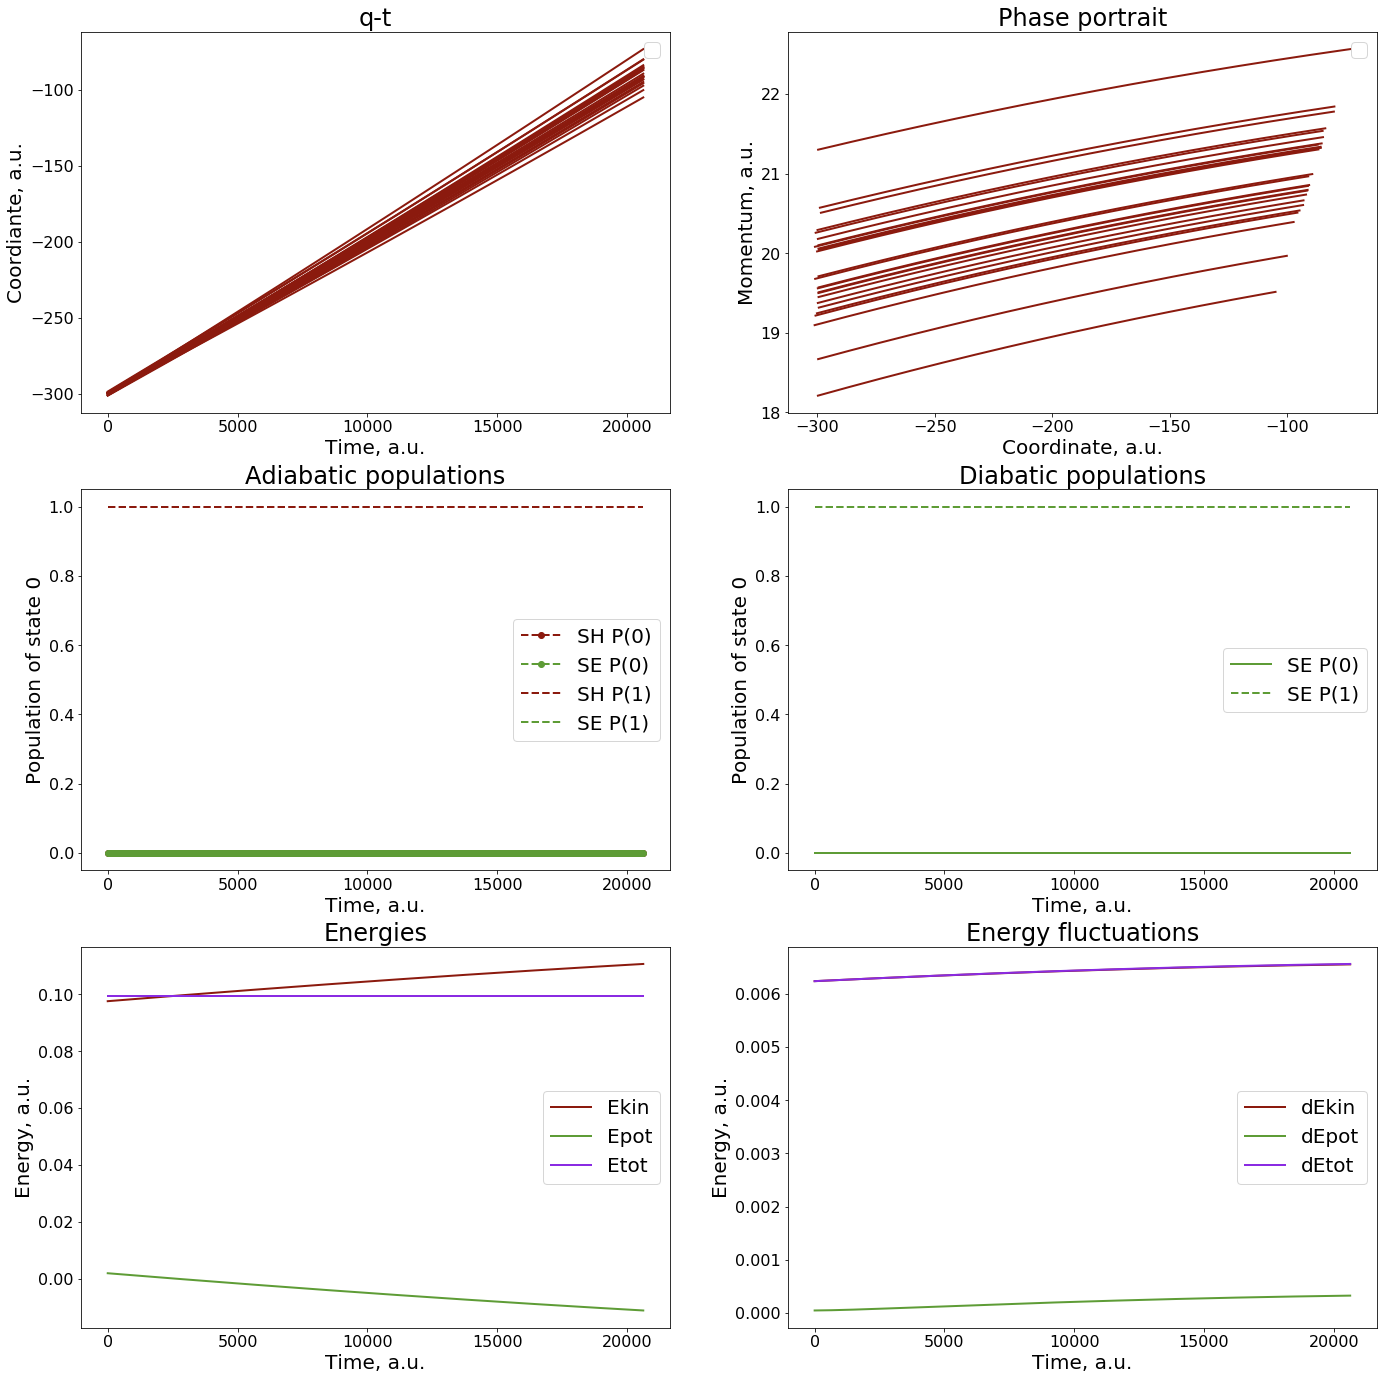

In [22]:
dyn_params.update({"prefix":"T2-2-2"})
model_params = {"model":1, "model0":1}
res = dynamics_recipes_Ehrenfest.Ehrenfest_dia0_dia_diah(q, p, iM, dyn_params, compute_model, model_params, init_elec, rnd)
plot_dyn(res)

<a name="case-2-2"></a>
[Back to TOC](#TOC)

[Back to Dynamics section](#dynamics)

### Case 2.2.

* Initial conditions - **adiabatic**
* TDSE propagation - **diabatic**
* Hamiltonian function return - **diabatic** properties


No handles with labels found to put in legend.
No handles with labels found to put in legend.


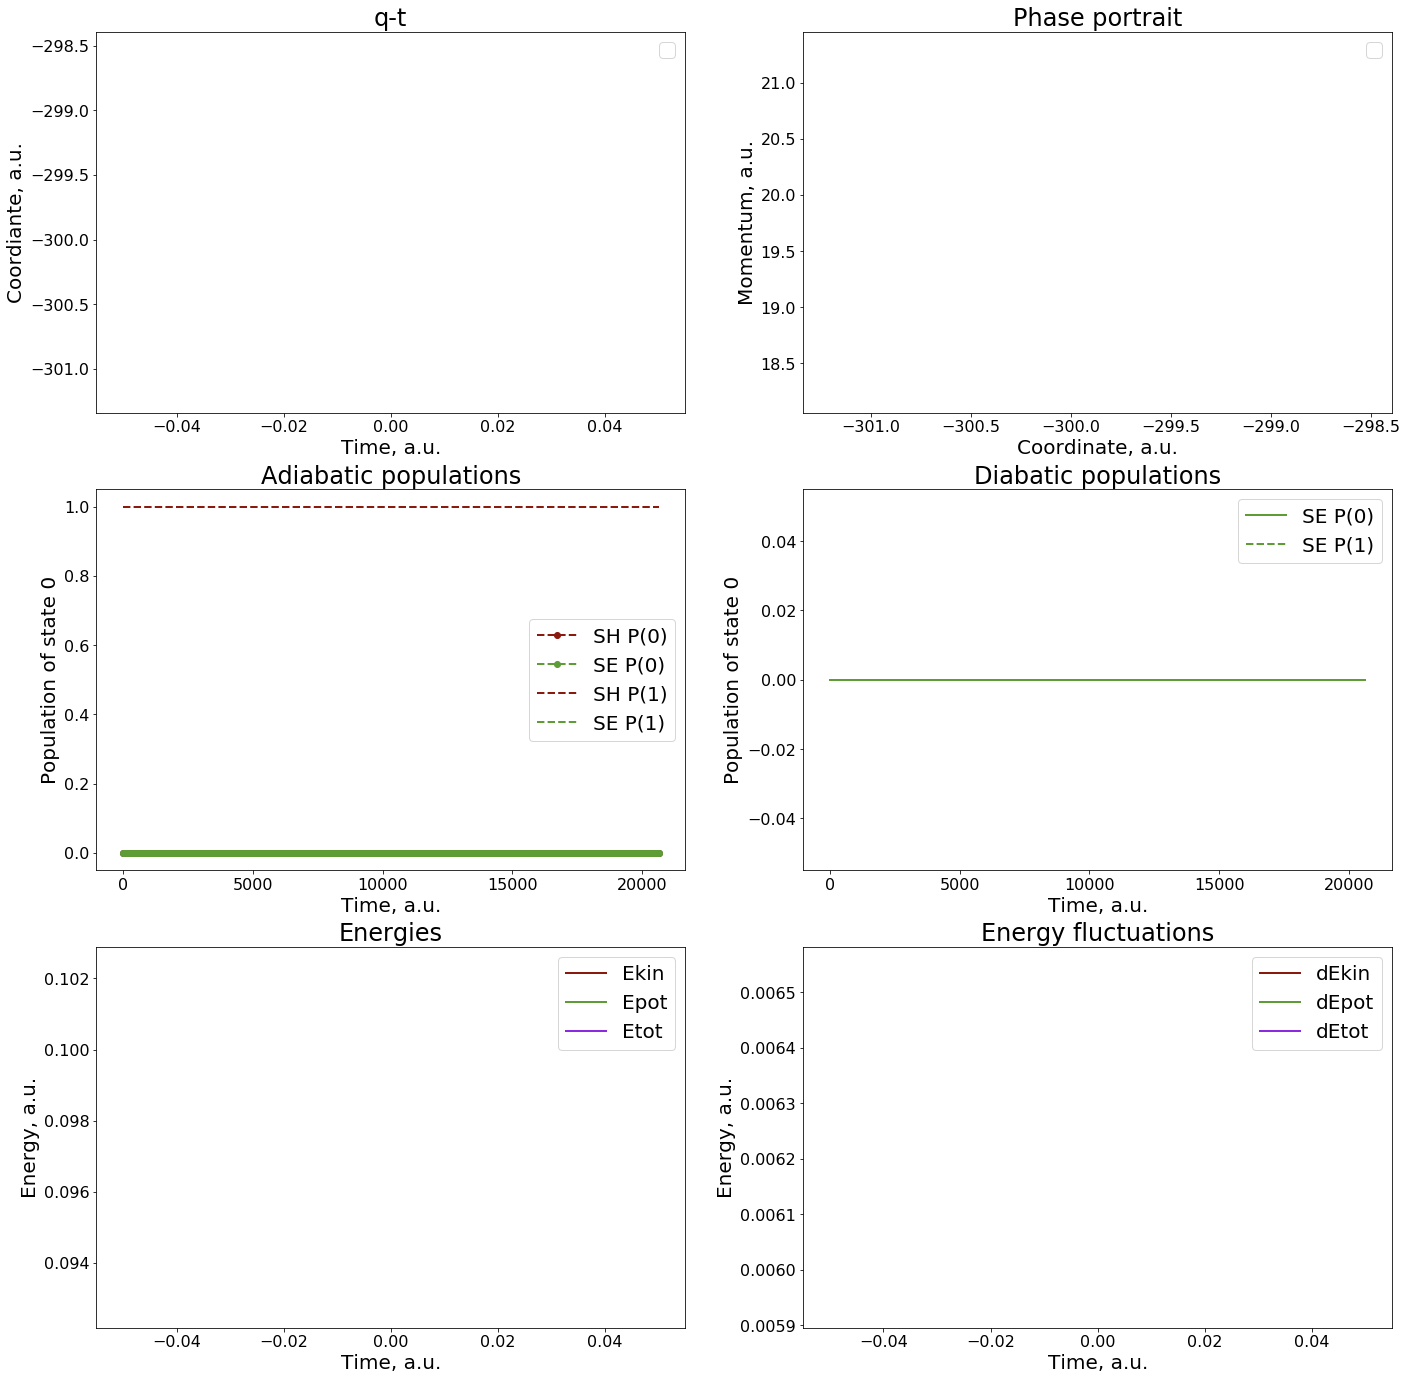

In [23]:
dyn_params.update({"prefix":"T2-2-2"})
model_params = {"model":1, "model0":1}
res = dynamics_recipes_Ehrenfest.Ehrenfest_adi0_dia_diah(q, p, iM, dyn_params, compute_model, model_params, init_elec, rnd)
plot_dyn(res)